# Ultimate Technologies Inc. Take-Home Challenge

## Part 1 ‐ Exploratory data analysis

In [49]:
import pandas as pd
import urllib
import json
import unidecode
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import datetime
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [50]:
# load the 'logins' dataset
file_path = r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 34 Effective Interviewing\1631809090_1481053515_ultimate_challenge_3_ (2)\ultimate_challenge\logins.json'

with open(file_path, 'r') as f:
        data = json.load(f)

In [51]:
# Explore the logins dataset
df = pd.DataFrame(data)
df.shape

(93142, 1)

In [52]:
df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   login_time  93142 non-null  object
dtypes: object(1)
memory usage: 727.8+ KB


In [54]:
# Change the datatype to datetime64
df['login_time'] = pd.to_datetime(df['login_time'], format='%Y-%m-%d %H:%M:%S')

In [55]:
# Check the login time range
login_time_min = df['login_time'].min()
login_time_max = df['login_time'].max()

print(f"login time range: {login_time_min} to {login_time_max}") 

login time range: 1970-01-01 20:12:16 to 1970-04-13 18:57:38


In [56]:
# Replace the year of each datetime object to 2014
df['login_time'] = df['login_time'].apply(lambda x: x.replace(year=2014))

# Check the first few rows to verify the changes
df.head()

,login_time
0,2014-01-01 20:13:18
1,2014-01-01 20:16:10
2,2014-01-01 20:16:37
3,2014-01-01 20:16:36
4,2014-01-01 20:26:21


In [57]:
login_time_min = df['login_time'].min()
login_time_max = df['login_time'].max()

print(f"login time range: {login_time_min} to {login_time_max}") 

login time range: 2014-01-01 20:12:16 to 2014-04-13 18:57:38


In [58]:
login_data = df.set_index('login_time')

# Create a column to count logins, since we'll aggregate by counting
login_data['login_count'] = 1

# Resample to aggregate login counts by 15-minute intervals
aggregated_logins = login_data.resample('15T').count()

# The 'login_count' column now contains the number of logins in each 15-minute interval
aggregated_logins.head()

,login_count
login_time,
2014-01-01 20:00:00,2
2014-01-01 20:15:00,6
2014-01-01 20:30:00,9
2014-01-01 20:45:00,7
2014-01-01 21:00:00,1


In [59]:
login = aggregated_logins.reset_index()

In [60]:
login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9788 entries, 0 to 9787
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   login_time   9788 non-null   datetime64[ns]
 1   login_count  9788 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 153.1 KB


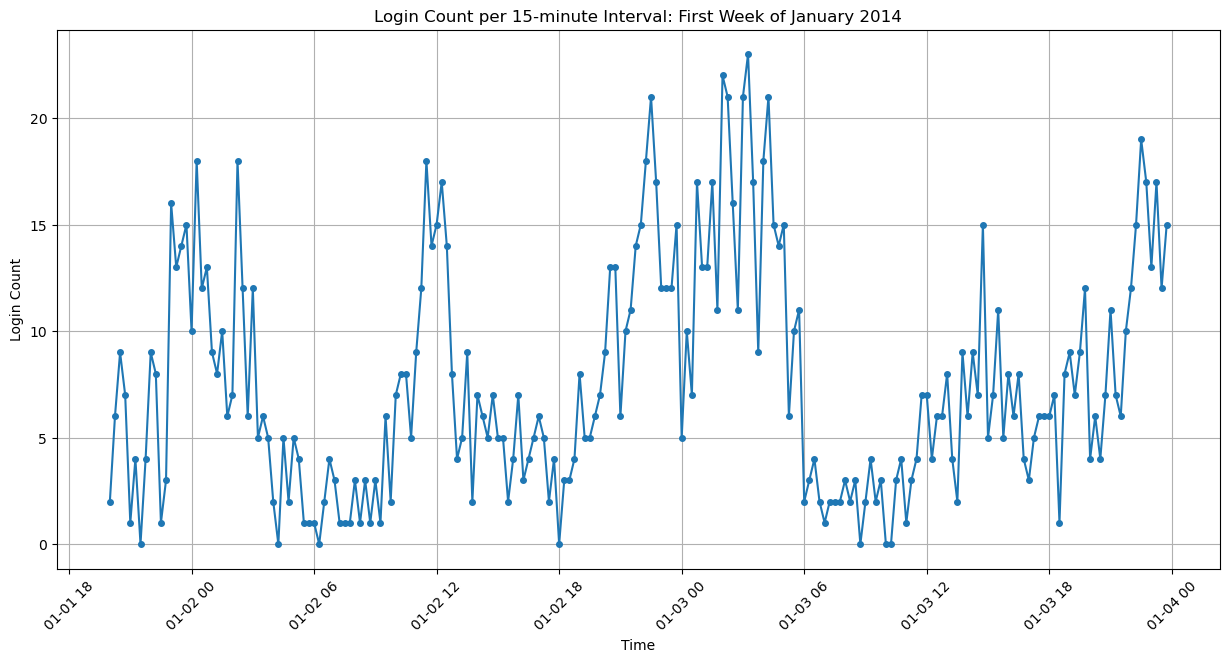

In [68]:
first_week_jan = login['2014-01-01': '2014-01-03']

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(first_week_jan.index, first_week_jan['login_count'], marker='o', linestyle='-', markersize=4)
plt.title('Login Count per 15-minute Interval: First Week of January 2014')
plt.xlabel('Time')
plt.ylabel('Login Count')
plt.xticks(rotation=45)
plt.grid(True)

plt.show()

# Login spikes during midnight and noon.

C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_6540\447201062.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_time_range['time_of_day'] = total_time_range.index.time
C:\Users\JIYOON JUNG\AppData\Local\Temp\ipykernel_6540\447201062.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  total_time_range['minutes_past_midnight'] = total_time_range.index.hour * 60 + total_time_range.index.minute


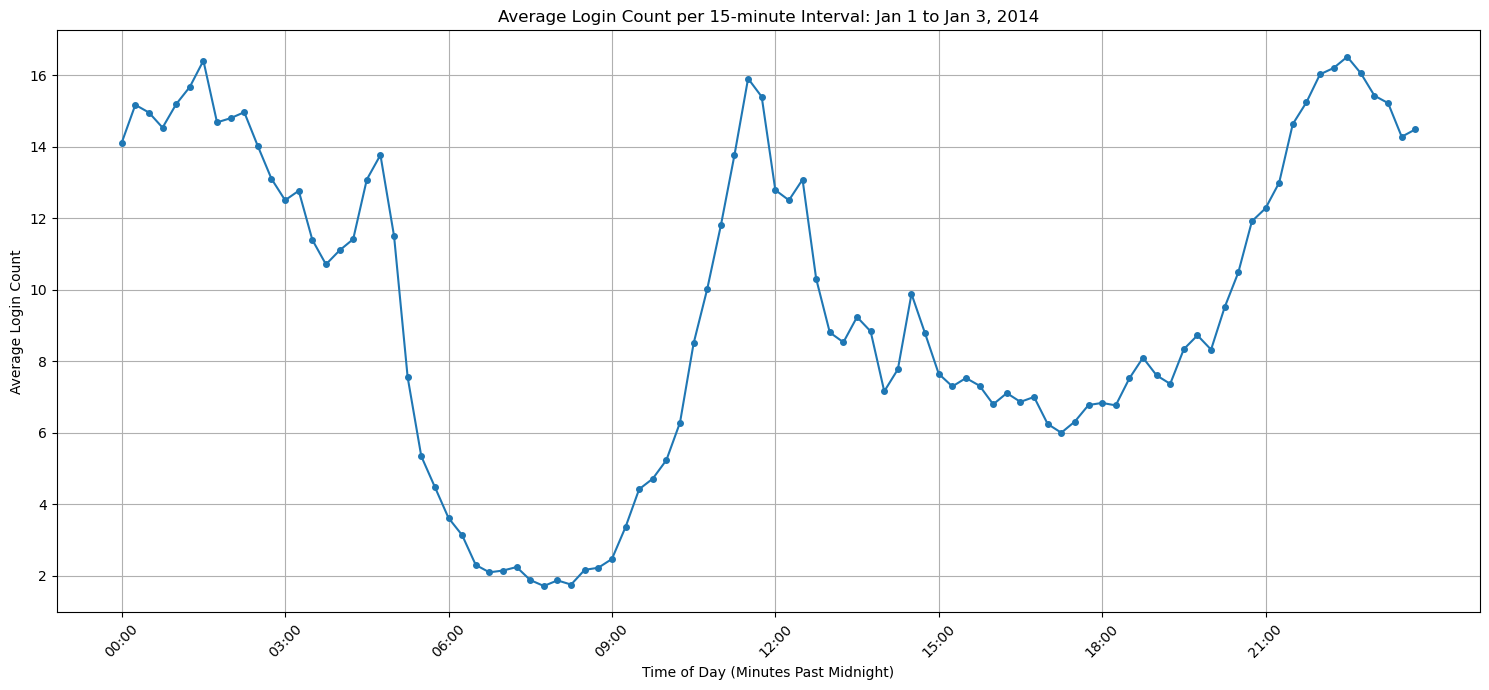

In [73]:
total_time_range = login['2014-01-01': '2014-04-13']

# First, ensure index is not already a time only format
total_time_range['time_of_day'] = total_time_range.index.time

# Convert 'time_of_day' to minutes past midnight
total_time_range['minutes_past_midnight'] = total_time_range.index.hour * 60 + total_time_range.index.minute

# Group by 'minutes_past_midnight' and calculate the mean login count for each 15-minute interval across the selected days
average_logins_per_time = total_time_range.groupby('minutes_past_midnight')['login_count'].mean()

# Plotting
plt.figure(figsize=(15, 7))
plt.plot(average_logins_per_time.index, average_logins_per_time, marker='o', linestyle='-', markersize=4)
plt.title('Average Login Count per 15-minute Interval: Jan 1 to Jan 3, 2014')
plt.xlabel('Time of Day (Minutes Past Midnight)')
plt.ylabel('Average Login Count')
plt.xticks(rotation=45)
plt.grid(True)

# Optional: Improve x-axis readability by converting minutes back to time strings for some tick labels
time_ticks = range(0, 24*60, 180)  # Every 3 hours
time_labels = [f'{t//60:02d}:{t%60:02d}' for t in time_ticks]
plt.xticks(time_ticks, time_labels)

plt.tight_layout()
plt.show()

## Part 2 ‐ Experiment and metrics design

#### 1. What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?

The key success metric for the experiment encouraging driver partners to serve both Gotham and Metropolis by reimbursing toll costs is the 'increase in cross-city trips'. This metric directly reflects the objective of reducing the financial barrier to cross-city driving, making it the most relevant and quantifiable measure of success.

##### Secondary Metrics:

* Rider wait times: Lower wait times indicate improved driver availability.
* Driver earnings: Increased earnings can encourage sustained behavior change.
* Rider satisfaction: Higher satisfaction could result from more available rides. 
* Cost-benefit analysis: Evaluates the financial viability of toll reimbursement.

#### 2. Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:

* a) how you will implement the experiment
* b) what statistical test(s) you will conduct to verify the significance of the observation
* c) how you would interpret the results and provide recommendations to the city operations team along with any caveats.

#### a) Implementation of the Experiment

Time Frame: Choose a testing period (e.g., 3 months) to observe the effects before and after implementing the toll reimbursement. Ensure to account for any seasonal variations by comparing the same period in consecutive years or by using a control group.

Selection of Participants: Randomly select a group of driver partners to receive toll reimbursement (treatment group) and another group that does not receive reimbursement (control group). Ensure that both groups are statistically similar in terms of past activity, hours driven, and other relevant characteristics.

Data Collection: Collect data on the number of cross-city trips made by drivers in both groups during the experiment. Additionally, gather data on secondary metrics such as driver earnings, rider wait times, and rider satisfaction scores.

Communication: Clearly communicate the experiment's scope, duration, and terms to participating drivers to ensure compliance and minimize biases.

#### b) Statistical Tests to Verify Significance
Difference in Means Test (e.g., t-test): After the experiment, use a two-sample t-test to compare the mean number of cross-city trips between the treatment and control groups. This test will help determine if the observed difference in cross-city trips is statistically significant.

Regression Analysis: To account for other variables that might affect the number of cross-city trips, conduct a regression analysis with the number of cross-city trips as the dependent variable and group assignment (treatment or control), time of day, day of the week, and any other relevant factors as independent variables.

Significance Level: Set an appropriate significance level (e.g., α = 0.05) prior to conducting the tests to determine the threshold for statistical significance.

#### c) Interpreting Results and Recommendations
Positive Outcome: If the statistical tests show a significant increase in cross-city trips for the treatment group compared to the control group, it suggests that toll reimbursement effectively encourages drivers to serve both cities. Recommend expanding the reimbursement program, keeping an eye on the cost-benefit analysis to ensure financial viability.

No Effect or Negative Outcome: If there's no significant difference or an unexpected decrease in cross-city trips, investigate further before making conclusions. It could be due to external factors, inadequate incentive, or operational issues. Surveys or interviews with participants might provide insights.

Caveats: Highlight any limitations of the experiment, such as the short duration, potential seasonal effects, or non-participation biases. Recommend ongoing monitoring of the program's impact and adjustments based on data-driven insights.

Further Analysis: Suggest conducting further experiments with different incentive structures or expanding the scope to include more drivers to validate findings and optimize the program.

In summary, a carefully designed experiment with robust statistical analysis can provide valuable insights into the effectiveness of toll reimbursement as a strategy to encourage cross-city service by driver partners. Clear interpretation of results, along with mindful consideration of caveats, will guide evidence-based recommendations for city operations.

## Part 3 ‐ Predictive modeling

In [74]:
# load the 'logins' dataset
file_path = r'C:\Users\JIYOON JUNG\Desktop\Springboard\Unit 34 Effective Interviewing\1631809090_1481053515_ultimate_challenge_3_ (2)\ultimate_challenge\ultimate_data_challenge.json'

with open(file_path, 'r') as f:
        data = json.load(f)

In [78]:
df = pd.DataFrame(data)
df.shape

(50000, 12)

In [79]:
df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [83]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
 12  active                  50000 non-null  object 
dtypes: bool(1), float64(6), int64(1), object(5)
memory usage: 4.6+ MB


In [82]:
df['active'] = np.where(df['trips_in_first_30_days'] > 0, 'active', 'inactive')

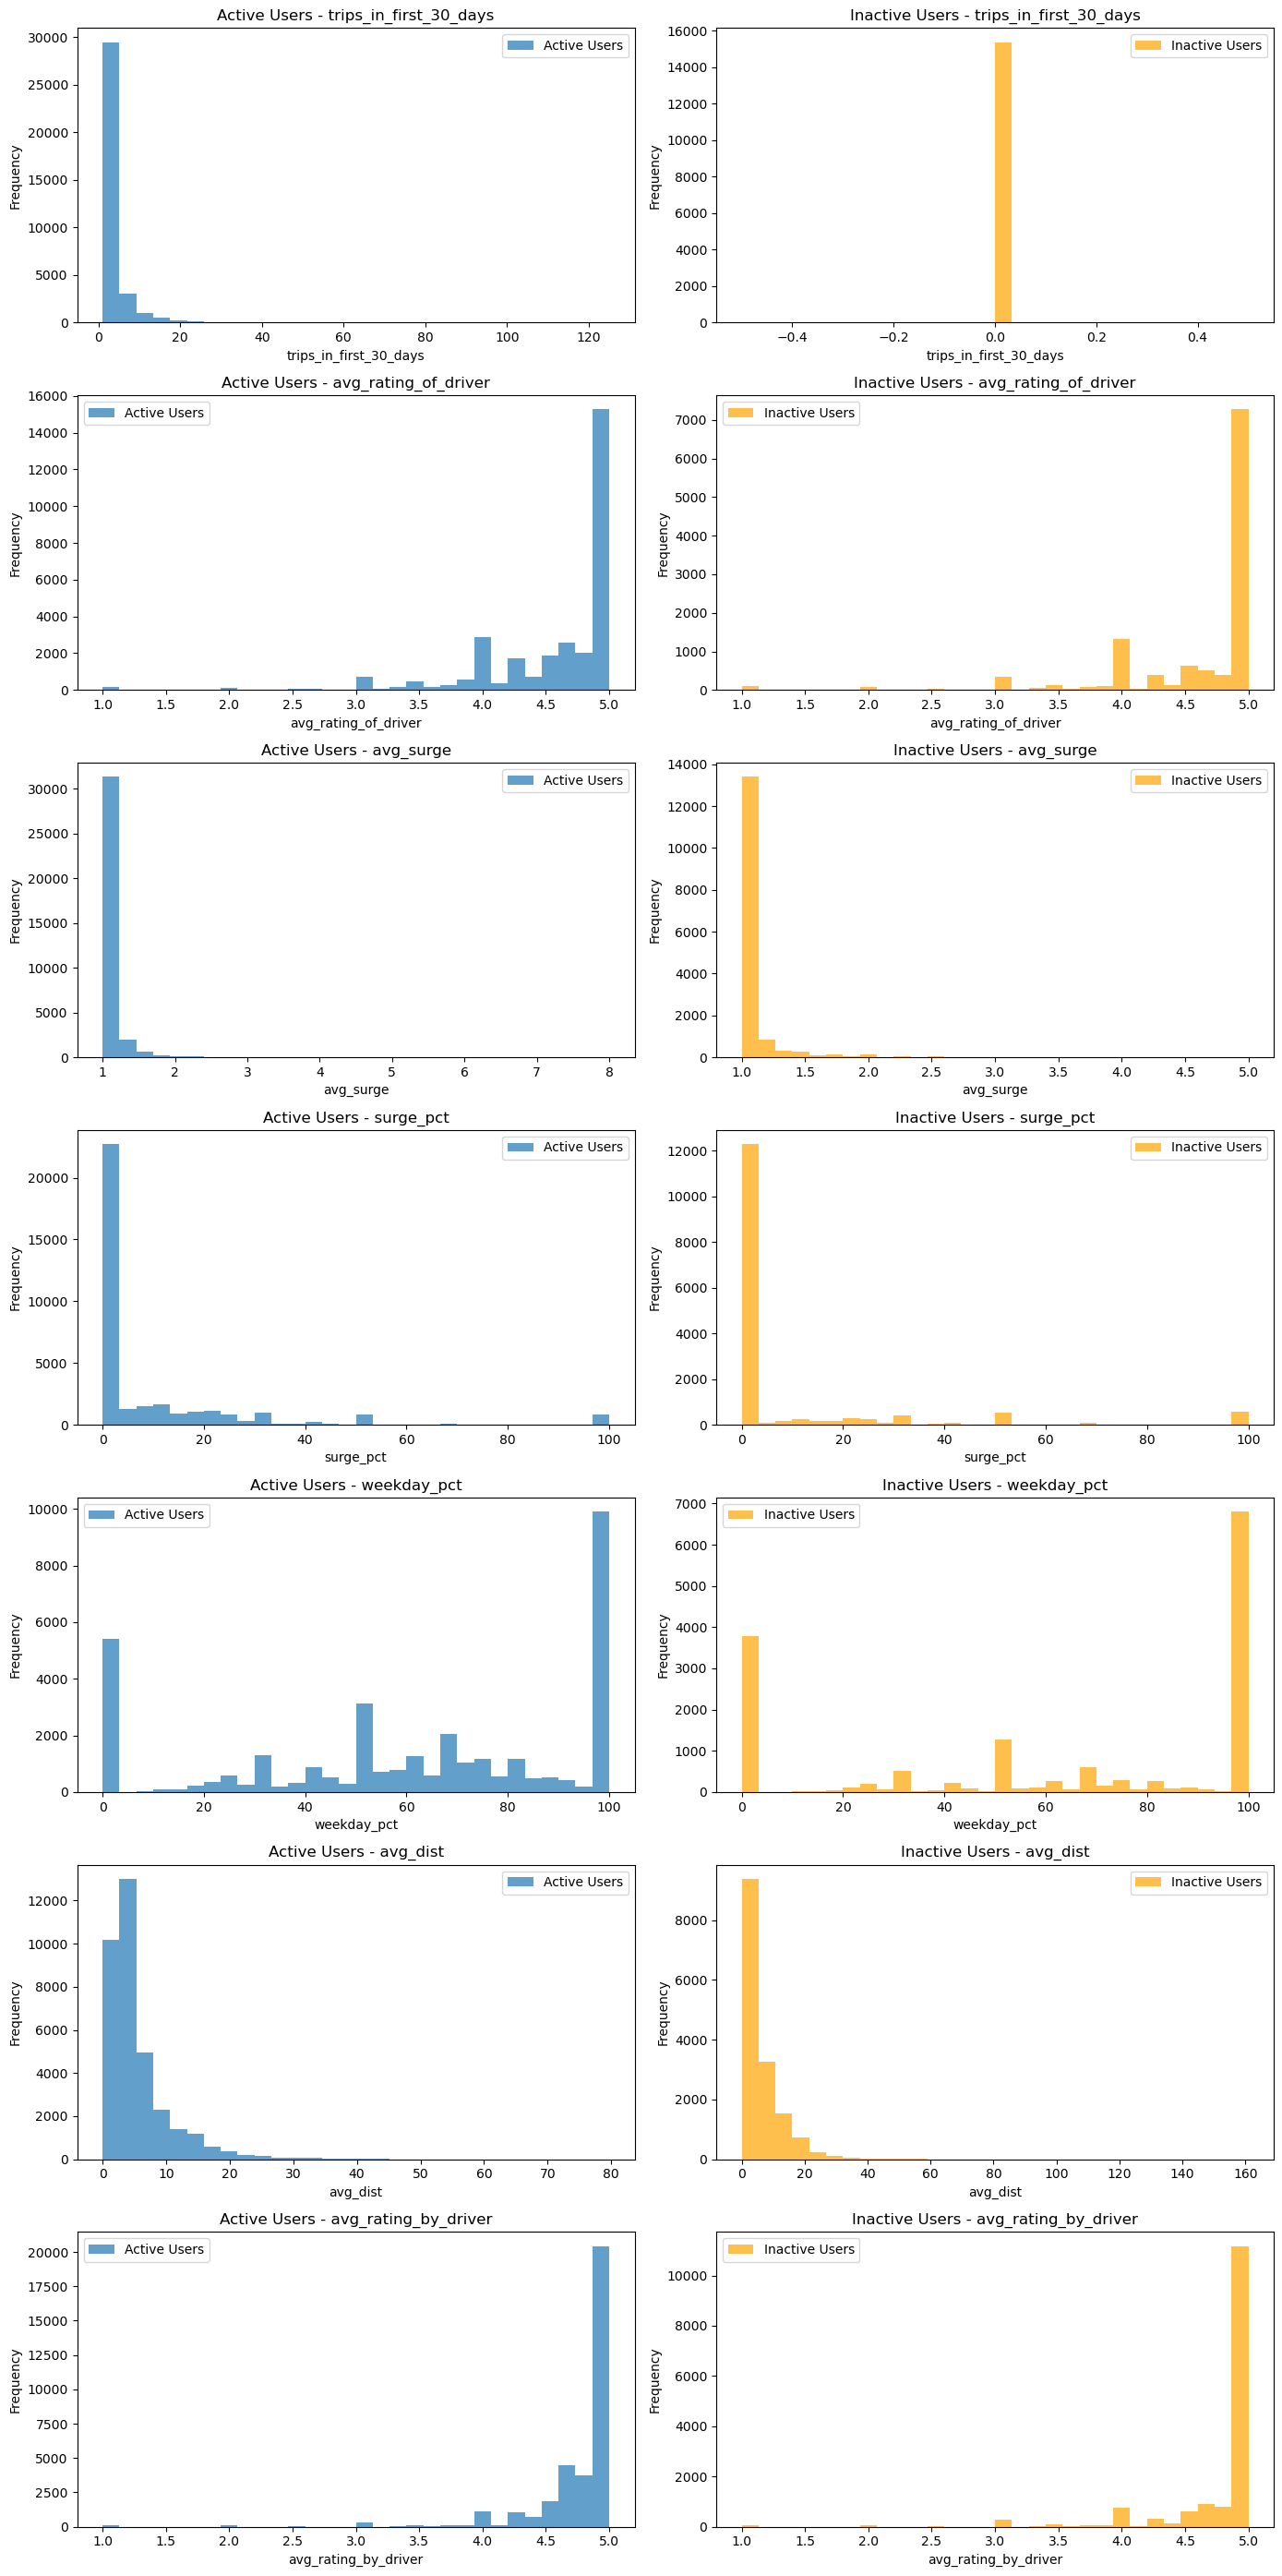

In [85]:
# Identify numeric columns for plotting histograms
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Set up the figure size and layout dynamically based on the number of numeric columns
num_cols = len(numeric_columns)
plt.figure(figsize=(14, 4 * num_cols))

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(num_cols, 2, 2*i-1)  # (num_rows, num_cols, index) for active users
    plt.hist(active_users[column], bins=30, alpha=0.7, label='Active Users')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Active Users - {column}')
    plt.legend()

    plt.subplot(num_cols, 2, 2*i)  # (num_rows, num_cols, index) for inactive users
    plt.hist(inactive_users[column], bins=30, alpha=0.7, color='orange', label='Inactive Users')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.title(f'Inactive Users - {column}')
    plt.legend()

plt.tight_layout()
plt.show()

In [86]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report
from sklearn.impute import SimpleImputer

# Assuming 'df' is your DataFrame

# Convert 'signup_date' and 'last_trip_date' from object to datetime
df['signup_date'] = pd.to_datetime(df['signup_date'])
df['last_trip_date'] = pd.to_datetime(df['last_trip_date'])

# Engineer a feature if not already done - Example: Days since signup
df['days_since_signup'] = (df['last_trip_date'] - df['signup_date']).dt.days

# Handle missing values
imputer = SimpleImputer(strategy='mean') # or median, most_frequent, etc.
df['avg_rating_of_driver'] = imputer.fit_transform(df[['avg_rating_of_driver']])
df['avg_rating_by_driver'] = imputer.fit_transform(df[['avg_rating_by_driver']])

# Encode categorical variables
label_encoder = LabelEncoder()
df['city'] = label_encoder.fit_transform(df['city'])
df['phone'] = label_encoder.fit_transform(df['phone'].astype(str))
df['active'] = label_encoder.fit_transform(df['active'])

# Convert boolean column to int
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# Define features and target
X = df.drop(['signup_date', 'last_trip_date', 'active'], axis=1)
y = df['active']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [87]:
# Initialize and train the Gradient Boosting Classifier
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier(random_state=42)

In [88]:
# Predictions
y_pred = model.predict(X_test_scaled)

# Evaluation metrics
print(f"Accuracy Score: {accuracy_score(y_test, y_pred)}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_pred)}")
print(classification_report(y_test, y_pred))

Accuracy Score: 1.0
ROC AUC Score: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6925
           1       1.00      1.00      1.00      3075

    accuracy                           1.00     10000
   macro avg       1.00      1.00      1.00     10000
weighted avg       1.00      1.00      1.00     10000



* Feature Engineering: Additional features might improve model performance. Consider exploring more interactions or derived features.
* Model Tuning: Experiment with different hyperparameters of GradientBoostingClassifier to optimize performance.
* Handling Missing Values: The strategy for imputation and whether to impute or drop rows/columns might impact results.
* Model Choice: Depending on the initial results, you might consider trying other models or ensemble methods.

#### Approach: Gradient Boosting Classifier

* Why Gradient Boosting?

* Performance: Gradient Boosting performs exceptionally well on a wide range of problems, particularly for binary classification tasks.
Handling Imbalanced Data: It can handle imbalanced datasets by adjusting the class weight.
Feature Importance: Provides insights into which features are most influential in predicting user activity.
Flexibility: Can handle missing data and doesn't require scaling of features.
Alternatives Considered

* Random Forest: A strong contender for classification tasks. Chose Gradient Boosting for its often superior performance on complex datasets and its ability to focus on hard-to-classify examples.
Logistic Regression: A simpler model that offers interpretability. Considered for baseline comparison but may underperform on non-linear relationships without careful feature engineering.
Neural Networks: Can capture complex relationships. Not chosen initially due to complexity, longer training times, and the need for large datasets.
Model Building Steps

* Feature Engineering: Extract features that might predict user activity, such as frequency of use in the first 30 days, average rating by the driver, surge multiplier average, etc. A critical feature would be calculating whether a user was active in the 6th month based on signup_date and last_trip_date.
Data Preprocessing: Handle missing values, encode categorical variables, and normalize/standardize features if necessary.

* Splitting Data: Split the dataset into training and testing sets to evaluate model performance.
Model Training and Tuning: Train the Gradient Boosting model. Use cross-validation and grid search to tune hyperparameters for optimal performance.
Evaluation: Use metrics like Accuracy, Precision, Recall, F1 Score, and ROC-AUC to evaluate model performance.
Model Validity and Performance Indicators

* ROC-AUC: Useful for imbalanced classes, as it evaluates the model's ability to distinguish between classes.
Precision and Recall: Important when the cost of false positives and false negatives differs; for instance, mistakenly predicting a user will be inactive might be more acceptable than missing an at-risk user.
F1 Score: Harmonic mean of precision and recall, providing a balance between them.
Confusion Matrix: Offers a detailed view of true positives, true negatives, false positives, and false negatives.


##### Concerns

Data Quality and Relevance: The model's validity heavily depends on the quality and relevance of the features selected. Irrelevant features can reduce model performance.
Overfitting: Gradient Boosting models can overfit if not carefully regularized and if the training is not stopped at the right time.
Future Changes in User Behavior: The model is built on historical data. Changes in user behavior or the platform might reduce its relevance over time.
Conclusion

The Gradient Boosting Classifier is chosen for its performance and flexibility. It's validated using metrics like ROC-AUC, Precision, Recall, F1 Score, and through a confusion matrix. Concerns include overfitting and the changing nature of user behavior. The model's validity would ideally be re-assessed periodically with new data to ensure it remains predictive over time.